In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append("..")
from audio import *

# FastAI Audio Features Notebook

This notebook is a fairly comprehensive look at the features of the library. It is meant to be oriented to beginners, and the main point is not to understand every single thing that is happening, but to understand how to copy/use the code on your own datasets so that you can try to solve audio problems in your domain without a huge degree of signals processing expertise. This is a long notebook and is best consumed by hopping around and checking out different features that you would like to try using now, and then trying them with your code/data. If you get stuck, reach out on the fastai forums in the [fastai audio thread](https://forums.fast.ai/t/deep-learning-with-audio-thread/38123) or contact us via PM [@baz](https://forums.fast.ai/u/baz/) or [@madeupmasters](https://forums.fast.ai/u/MadeUpMasters/) We also have a telegram group for audio ML. If you would like to join, message us on the forums.

# Table of Contents
1. [Preprocessing Features](#Preprocessing-Features)
    1. [Resampling](#Resampling)
    2. [Silence Removal](#Silence-Removal)
    3. [Segmentation](#Segmentation)
2. [Generating Images from Audio](#Generating-Images-from-Audio)
    1. [Spectrogram Generation](#Spectrogram-Generation)
    2. [Spectrogram Configuration and Fine Tuning](#Spectrogram-Configuration-and-Fine-Tuning)
    3. [Mel Frequency Cepstral Coefficients(MFCC)](#Mel-Frequency-Cepstral-Coefficients)
    4. [Delta and Acceleration Stacking](#Delta-and-Acceleration-Stacking)
3. [Transforms](#Transforms)
    1. [Mixup](#Mixup)
    2. [SpecAugment](#SpecAugment)
        1. [Frequency Masking](#Frequency-Masking)
        2. [Time Masking](#Time-Masking)
    3. [Rolling](#Rolling)
4. [Conclusion](#Conclusion)

#### First we grab our dataset, a set of 10 speakers for speaker identification

In [8]:
label_pattern = r'_([mf]\d+)_'
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
data_folder = datapath4file(url2name(data_url))
if not os.path.exists(data_folder): untar_data(data_url, dest=data_folder)
audios = AudioList.from_folder(data_folder)

In [5]:
audios

AudioList (3842 items)
AudioItem 3.28 seconds (52480 samples @ 16000hz),AudioItem 4.4 seconds (70400 samples @ 16000hz),AudioItem 5.32 seconds (85120 samples @ 16000hz),AudioItem 3.36 seconds (53760 samples @ 16000hz),AudioItem 3.8 seconds (60800 samples @ 16000hz)
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS

In [193]:
audios[0]

AudioItem AudioItem 3.28 seconds (52480 samples @ 16000hz)

# Preprocessing Features 

Preprocessing options currently consist of resampling, silence removal, and segmenting the clips, in that order. This happens when you label your items (e.g. call `label_from_folder()`). These actions can take several minutes, and possibly longer for large datasets, thus we automatically cache the results for you so that the process doesn't have to be repeated. This happens even if `cache_spectro=False` in your Config, that feature is for spectrogram caching only. This will allow you to try different configurations as quickly as possible. The caching happens at each stage, so if you change your settings for silence removal, the library will not need to repeat the resampling, but will instead pull the resampled files from the cache and resume silence removal.  

## Resampling

If you have multiple sample rates, you will have to resample to a single sample rate as your images won't be comparable (the time-axis (x-axis) of the spectrogram will have varied scales. 

Also you may sometimes want to resample from high sample rates to low sample rates. This will allow you to represent longer durations in the same space of a spectrogram (compressing the time axis). You can also achieve a similar effect by increasing the hop length of the spectrogram.

Keep in mind that by downsampling you will be throwing away any frequency information that is below 1/2 your sample rate. For example, at 16000hz, you will only be able to accurately represent frequencies 0-8000, so downsampling from 44100hz to 16000hz, you will lose information for frequencies in the range 8000hz-22050hz. For human voice this is okay, for music, it isn't. For more info read about Nyquist Theorem

**Resampling is as simple as setting the `resample_to` attribute of your config to the sample rate you want**, let's resample to 8000hz. This can be done after creation, or you can pass `resample_to=8000` as an argument by typing `config = AudioConfig(resample_to=8000)`

In [9]:
%%time
label_pattern = r'_([mf]\d+)_'
config = AudioConfig()
config.resample_to = 8000
rs_audio = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)

/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]


CPU times: user 1min 51s, sys: 1.29 s, total: 1min 53s
Wall time: 48 s


In [131]:
rs_audio

LabelLists;

Train: AudioLabelList (3074 items)
x: AudioList
AudioItem 3.28 seconds (26240 samples @ 8000hz),AudioItem 4.4 seconds (35200 samples @ 8000hz),AudioItem 3.36 seconds (26880 samples @ 8000hz),AudioItem 3.8 seconds (30400 samples @ 8000hz),AudioItem 2.92 seconds (23360 samples @ 8000hz)
y: CategoryList
f0004,m0002,f0001,f0005,m0005
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS;

Valid: AudioLabelList (768 items)
x: AudioList
AudioItem 2.48 seconds (19840 samples @ 8000hz),AudioItem 7.2 seconds (57600 samples @ 8000hz),AudioItem 5.48 seconds (43840 samples @ 8000hz),AudioItem 2.52 seconds (20160 samples @ 8000hz),AudioItem 2.76 seconds (22080 samples @ 8000hz)
y: CategoryList
f0002,m0003,f0005,m0005,f0004
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS;

Test: None

Note that we have the same number of files, but they've all been resampled to 8000hz.

For efficiency we use a polyphase resampling method instead of FFT-based. This will be faster except in rare cases where the greatest common denominator of the old sample rate and the new sample rate is low (< 20). Since we mostly use round numbers, this doesn't tend to happen, but if you suddenly decide to resample to a prime sample rate, you may seem your time balloon upward. 

Remember we are caching so while it took ~13 seconds to resample the first time, creating a new LabelList with the same settings and data will be nearly instant

In [132]:
%%time
config = AudioConfig()
config.resample_to = 8000
rs_audio = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)

CPU times: user 212 ms, sys: 40 ms, total: 252 ms
Wall time: 254 ms


## Silence Removal

Sometimes we have a dataset that is full of lengthy clips with lots of silence. A real world example is a marine biologist trying to identify whale calls in a recording. Most of the recording will be silence, along with some occasional noise that we need to classify (call or not a call). It would be helpful to remove the silence and split the clip into separate files with each noise so that we can build a classifier. The dataset we use below is not a good use case for splitting by silence, and we use it solely as a demonstration

If you set `config.remove_silence` to `True`, during preprocessing the clip will be segmented at any point where there is 2*`config.silence_padding` ms or more of silence, as defined by `config.silence_threshold` in decibels. Each segmented clip will retain `config.silence_padding` ms of silence on each side of the detected audio.

Note that we are creating a fresh AudioConfig object each time so that if you go out of order in this notebook, the results won't be affected

In [206]:
config_sr = AudioConfig(remove_silence = True)

In [207]:
config_sr.remove_silence, config_sr.silence_padding, config_sr.silence_threshold

(True, 200, 20)

In [208]:
# adjust the silence padding to 100ms and preprocess
config_sr.silence_padding = 100
audio_sr = AudioList.from_folder(data_folder, config=config_sr).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)

Note that after removing excess silence, and splitting clips based on silent portions, we now have ~6100 items in our dataset instead of 3842

In [209]:
print(len(audios))
audio_sr

3842


LabelLists;

Train: AudioLabelList (4928 items)
x: AudioList
AudioItem 0.7 seconds (11200 samples @ 16000hz),AudioItem 0.3 seconds (4800 samples @ 16000hz),AudioItem 0.8 seconds (12800 samples @ 16000hz),AudioItem 2.0 seconds (32000 samples @ 16000hz),AudioItem 0.7 seconds (11200 samples @ 16000hz)
y: CategoryList
f0004,f0004,f0004,m0002,f0001
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS;

Valid: AudioLabelList (1248 items)
x: AudioList
AudioItem 1.2 seconds (19200 samples @ 16000hz),AudioItem 1.4 seconds (22400 samples @ 16000hz),AudioItem 1.0 seconds (16000 samples @ 16000hz),AudioItem 2.2 seconds (35200 samples @ 16000hz),AudioItem 2.8 seconds (44800 samples @ 16000hz)
y: CategoryList
f0002,m0003,m0003,m0003,f0005
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS;

Test: None

Below you can see how the first clip has been split into 3 separate clips at points where there is 200ms of sound that measures less than 20db, and the silence at the start and end has been removed. What was originally 3.28s is now 1.8s. Note again that this is not a good idea for this dataset. 

Original audio: 3.28s
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


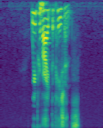

Split audio:
0.7 s
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/sh_20-100/f0004_us_f0004_00446.wav-362738ae937c85d847bd0273e29420f4/1.wav
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/sh_20-100/f0004_us_f0004_00446.wav-362738ae937c85d847bd0273e29420f4/1.wav


0.3 s
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/sh_20-100/f0004_us_f0004_00446.wav-362738ae937c85d847bd0273e29420f4/2.wav
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/sh_20-100/f0004_us_f0004_00446.wav-362738ae937c85d847bd0273e29420f4/2.wav


0.8 s
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/sh_20-100/f0004_us_f0004_00446.wav-362738ae937c85d847bd0273e29420f4/0.wav
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/sh_20-100/f0004_us_f0004_00446.wav-362738ae937c85d847bd0273e29420f4/0.wav


In [214]:
print(f"Original audio: {audios[0].duration}s")

audios[0].show()
print("Split audio:")
for i in range(3):
    print(audio_sr.train[i][0].duration, "s")
    print(audio_sr.train[i][0].path)
    audio_sr.train[i][0].show()

## Segmentation

Segmentation will chop your audio clips up into equal intervals for you. For example if you have a 7.2s clip, and would like 1s long clips, it will chop it into 8 1-second-long clips (the last will be padded to be a full second). 

Note: It is recommended instead to set the `duration` attribute of your config to the number of milliseconds you want your spectrograms to be. Only use segmentation if you want the actual underlying audio clips to be chopped into pieces and saved. In most cases this will be slower, consume more memory, and train to a lower accuracy. 

The code below will remove silence, and then create equal size (500ms) chunks for us so that we can compare to
the example that just removes silence. Note that we now have around 24,000 clips.

In [273]:
config_segment = AudioConfig(remove_silence = True, segment_size = 500)
audio_segment = AudioList.from_folder(data_folder, config=config_segment).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)
audio_segment

LabelLists;

Train: AudioLabelList (19244 items)
x: AudioList
AudioItem 0.5 seconds (8000 samples @ 16000hz),AudioItem 0.5 seconds (8000 samples @ 16000hz),AudioItem 0.5 seconds (8000 samples @ 16000hz),AudioItem 0.5 seconds (8000 samples @ 16000hz),AudioItem 0.5 seconds (8000 samples @ 16000hz)
y: CategoryList
f0004,f0004,f0004,f0004,f0004
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS;

Valid: AudioLabelList (4777 items)
x: AudioList
AudioItem 0.5 seconds (8000 samples @ 16000hz),AudioItem 0.5 seconds (8000 samples @ 16000hz),AudioItem 0.5 seconds (8000 samples @ 16000hz),AudioItem 0.5 seconds (8000 samples @ 16000hz),AudioItem 0.5 seconds (8000 samples @ 16000hz)
y: CategoryList
f0002,f0002,f0002,m0003,m0003
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS;

Test: None

Segmented audio:
0.5 s
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/1.wav-ca3d66ae7253cfe5171b06c793fcdec0/0.wav
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/1.wav-ca3d66ae7253cfe5171b06c793fcdec0/0.wav


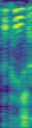

0.3 s
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/1.wav-ca3d66ae7253cfe5171b06c793fcdec0/1.wav
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/1.wav-ca3d66ae7253cfe5171b06c793fcdec0/1.wav


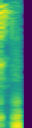

0.5 s
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/2.wav-eb31fa219886bc94c94a24f2aa457256/0.wav
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/2.wav-eb31fa219886bc94c94a24f2aa457256/0.wav


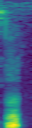

0.1 s
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/2.wav-eb31fa219886bc94c94a24f2aa457256/1.wav
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/2.wav-eb31fa219886bc94c94a24f2aa457256/1.wav


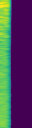

0.5 s
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/0.wav-f218f9cb93f361cf0986215977e348af/0.wav
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/0.wav-f218f9cb93f361cf0986215977e348af/0.wav


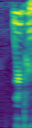

0.5 s
/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/0.wav-f218f9cb93f361cf0986215977e348af/1.wav
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/s_500/0.wav-f218f9cb93f361cf0986215977e348af/1.wav


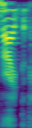

In [276]:
print("Segmented audio:")
for i in range(6):
    print(audio_segment.train[i][0].duration, "s")
    print(audio_segment.train[i][0].path)
    audio_segment.train[i][0].show()

## Caching

Spectrogram generation is done through TorchAudio, but even optimized for torch, discrete fourier transforms are slow (several ms per item) and are a time bottleneck. Read/write from disk is almost always faster, so we offer the option to cache files (.pt files, saved torch tensors). If you set `cache_spectro = True`, your spectrograms will be saved to `cache_folder` inside of the same folder where your data is stored. You shouldn't need to change this, and the current implementation is a bit rigid, so you can only choose the subfolder of your datafolder where it is located, you cannot currently choose a location outside of that folder. It is set by default to be '.cache' 

In [280]:
config.cache_dir

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache')

Files that start with a . are hidden in Linux, so if you're searching in the terminal you may need to type `ls -a`.

In [281]:
! ls {config.cache_dir}

ls: cannot access '/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache': No such file or directory


The spectrograms are stored in a folder with the hash of the set of settings you used. The preprocessing is stored in it's own folder. rs_8000 is resample to 8000, sh_20-200 is silence removal with a threshold of 20dB and padding 200ms, and s_1000 is segment into 1000ms chunks. 

Note that for large datasets this can be potentially huge amounts of data (~20-50GB) so if you are working with a large dataset you may want to clear the cache each time you change settings. We currently don't offer a clear_cache function as we don't want to risk dataloss, so you must manually remove the folder 

In [ ]:
!rm -rf {str(data_folder / '.cache')}

# Generating Images from Audio

Using raw audio with deep neural nets is promising, but has had mixed results and is much more expensive to train. The vast majority of models use a spectral extraction of the audio rather than the raw audio itself. The most common is the melspectrogram (If you don't know what a spectrogram or the mel-scale are, please see the Intro to Audio notebook)

## Spectrogram Generation

The library will automatically create melspectrograms for you on the fly, transform them, and train. To do this you just need to set use_spectro = True. 

You can deactivate this warning by passing `no_check=True`.
------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


/opt/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py:269: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([3, 128, 141]), torch.Size([3, 128, 161]), torch.Size([3, 128, 127]), torch.Size([3, 128, 132]), torch.Size([3, 128, 112]), torch.Size([3, 128, 162]), torch.Size([3, 128, 273]), torch.Size([3, 128, 109]), torch.Size([3, 128, 128]), torch.Size([3, 128, 133]), torch.Size([3, 128, 142]), torch.Size([3, 128, 96]), torch.Size([3, 128, 184]), torch.Size([3, 128, 113]), torch.Size([3, 128, 132]), torch.Size([3, 128, 179]), torch.Size([3, 128, 149]), torch.Size([3, 128, 127]), torch.Size([3, 128, 263]), torch.Size([3, 128, 117]), torch.Size([3, 128, 199]), torch.Size([3, 128, 116]), torch.Size([3, 128, 118]), torch.Size([3, 128, 93]), torch.Size([3, 128, 99]), torch.Size([3, 128, 87]), torch.Size([3, 128, 207]), torch.Size([3, 128, 108]), torch.Size([3, 128, 133]), torch.Size([3, 128, 138]), torch.

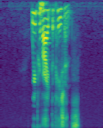

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002


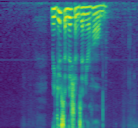

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


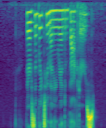

In [217]:
#use spectrograms (this by default is true, and currently there is no real way to use raw audio)
config_sg = AudioConfig(use_spectro=True)
audios_sg = AudioList.from_folder(data_folder, config=config_sg).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)
db_sg = audios_sg.databunch(bs=64)
db_sg.show_batch()

As you can see we are generating spectrograms, but they are unequal widths, because of the varying durations of the audio. As mentioned in the Getting Started guide, you can fix this by either setting `duration` (both are how long you want clips to be in ms). Duration should train better in almost all cases so we'll go with that. If your audios are of exactly the same length (rarely the case) you can proceed without setting `duration`/`max_to_pad`

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


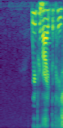

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002


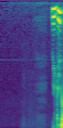

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


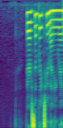

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav
Label: f0005


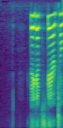

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav
Label: m0005


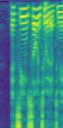

In [221]:
config_max_to_pad = AudioConfig(use_spectro=True, max_to_pad=2000)
audios_max_to_pad = AudioList.from_folder(data_folder, config=config_max_to_pad ).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)
db_max_to_pad = audios_max_to_pad.databunch(bs=64)
db_max_to_pad.show_batch(5)

With `max_to_pad` the shorter clips are padded with zeros and the longer ones are cropped taking the first 4000ms of audio. `duration` will perform better because instead of taking just the first 4000ms of audio, it will take the equivalent of 4000ms at random from the spectrogram and will not throw away any data. This will be more and more important the lower you set `duration`/`max_to_pad`, or the more variation of audio length in your dataset there is

In [250]:
learn = audio_learner(db_max_to_pad)
learn.fit_one_cycle(5, slice(4e-3, 4e-2))
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3))

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004
0.48s-2.48s of original clip


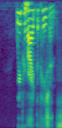

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
0.96s-2.96s of original clip


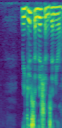

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001
0.06s-2.06s of original clip


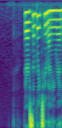

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav
Label: f0005
1.6s-3.6s of original clip


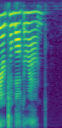

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav
Label: m0005
0.42s-2.42s of original clip


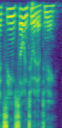

In [222]:
config_duration = AudioConfig(use_spectro=True, duration=2000)
audios_duration = AudioList.from_folder(data_folder, config=config_duration ).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)
db_duration = audios_duration.databunch(bs=64)
db_duration.show_batch(5)

Note that duration will also tell you which part of the clip you're listening to and seeing, and it will be different every time you look at an item

In [251]:
learn = audio_learner(db_duration)
learn.fit_one_cycle(5, slice(4e-3, 4e-2))
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3))

## Spectrogram Configuration and Fine Tuning

If you've explored the config object at all, you may notice it has an `sg_cfg` inside of it. This is where all your sg settings are held, and by adjusting them like any other hyperparameter you can train your models to higher degrees of accuracy. We won't cover every setting here, just enough to get more detailed spectrograms. For a deep-dive on each of these settings, see the **Intro to Audio** guide. 

In [282]:
config_tune = AudioConfig(use_spectro=True, duration=2000)
config_tune.sg_cfg

SpectrogramConfig(f_min=0, f_max=8000, hop=256, n_fft=2560, n_mels=128, pad=0, to_db_scale=True, top_db=100, ws=None, n_mfcc=20)

You can alter these settings and the spectrograms will change. Here we make the spectrograms larger by increasing the number of mel bins (taller spectrogram) and decreasing the hop (wider spectrogram)

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004
0.18s-2.18s of original clip


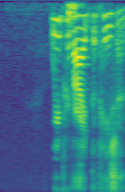

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
1.44s-3.44s of original clip


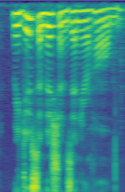

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001
1.2s-3.2s of original clip


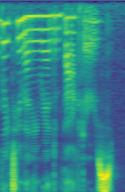

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav
Label: f0005
0.61s-2.61s of original clip


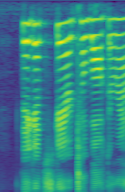

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav
Label: m0005
0.9s-2.9s of original clip


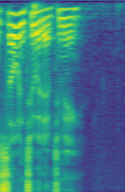

In [283]:
sg_cfg_tune = SpectrogramConfig(hop=256, n_mels=192)
config_tune.sg_cfg = sg_cfg_tune
audios_tune = AudioList.from_folder(data_folder, config=config_tune).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)
db_tune = audios_tune.databunch(bs=64)
db_tune.show_batch(5)

Let's train and check our results

In [252]:
learn = audio_learner(db_tune)
learn.fit_one_cycle(5, slice(4e-3, 4e-2))
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3))

It looks like these settings might give us slightly better results, but it's hard to tell with such an easy dataset. 

## Mel-Frequency Cepstral Coefficients

Mel frequency cepstral coefficients are a form of audio extraction used in speech/voice recognition. They can train to pretty high degrees of accuracy extremely quickly, but given the limited amount of data they provide to the model, they often underperform melspectrograms in our testing, but can sometimes beat melspec, and can also be considered for part of an ensemble.

Trying them out is fast and easy, just set `config.mfcc = True`, and your melspectrogram will be replaced by an mfcc. Note that`use_spectro` still should be True. Also you can set the number of coefficients used by altering your Spectrogram Configs n_mfcc setting, below that would mean `config_mfcc.sg_cfg.n_mfcc = 40` or whatever value you want. Your image will then be `n_mfcc` pixels tall, in this case 20. 

In [262]:
config_mfcc = AudioConfig(use_spectro=True, duration=4000, mfcc=True)
audios_mfcc = AudioList.from_folder(data_folder, config=config_mfcc).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)
db_mfcc = audios_mfcc.databunch(bs=64)
db_mfcc.show_batch()


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
0.37s-4.37s of original clip


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


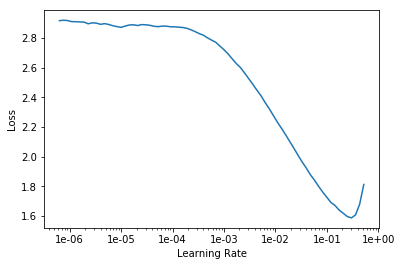

In [259]:
learn = audio_learner(db_mfcc)
learn.lr_find(); learn.recorder.plot()

In [260]:
learn.fit_one_cycle(5, slice(7e-3, 7e-2))

In [261]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3))

## Delta and Acceleration Stacking

Delta and acceleration appending/stacking means you take the 1st derivative (delta) and 2nd derivative (accelerate) and pass them to your model in some way (in our case by stacking them in the 2nd and 3rd channels). This is very common to see in ML audio papers and now to reproduce, all you need to do is set `delta=True` and the 2nd and 3rd channel of your image will be the delta and accelerate of your spectrogram/mfcc. 

The library will display the channels to you as separate 1 channel images because combined as 1 RGB image, it will be nonsensical. 

Also you may need to lower batch size when stacking, as 3x the memory will be consumed.

In [268]:
config_mfcc_stack = AudioConfig(mfcc=True, delta=True, duration=4000)
audios_mfcc_stack = AudioList.from_folder(data_folder, config=config_mfcc_stack).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)
db_mfcc_stack = audios_mfcc_stack.databunch(bs=32)
db_mfcc_stack.show_batch(5)


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
0.35s-4.35s of original clip


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav
Label: f0005


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav
Label: m0005


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


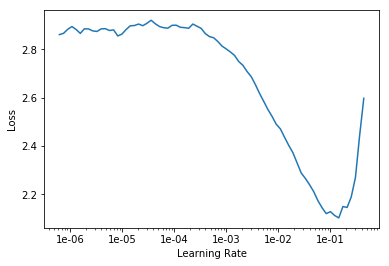

In [270]:
learn = audio_learner(db_mfcc_stack)
learn.lr_find(); learn.recorder.plot()

In [271]:
learn.fit_one_cycle(5, slice(7e-3, 7e-2))
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3))

# Transforms

The above section covered basic training and the types of features you can extract to feed to an image classifier. Once those spectrograms are generated, you can perform real-time transforms on them in order to prevent overfitting and obtain better results. The normal transforms you would use for an image don't apply to spectrograms. For example, a horizontal flip of a cat is still a cat, but a horizontal flip of a spectrogram represents a different sound (something close to the reverse of it) and for most cases, this would change classification. 

## Mixup

Mixup isn't a typical transform, and is actually applied directly to the learner. It takes two images of different classifications and combines them into one. Thanks to fastai callbacks, mixup in audio is the easiest thing ever, and it works really well. Just add .mixup when you create your learner and you're all set. Check out the competition notebooks to see it in action. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


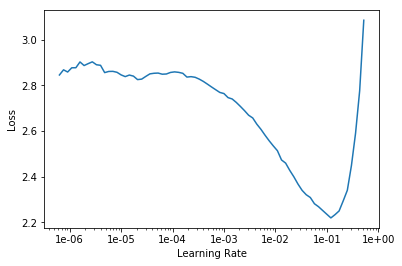

In [291]:
config_sg = AudioConfig(use_spectro=True, duration=4000)
db_sg = (AudioList.from_folder(data_folder, config=config_sg).
         split_by_rand_pct(.2, seed=4).
         label_from_re(label_pattern).
         databunch(bs=32))
learn = audio_learner(db_sg).mixup()
learn.lr_find();learn.recorder.plot()

In [292]:
learn.fit_one_cycle(5, slice(7e-3, 7e-2))
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3))

Note that our training loss is 10x higher after the first epoch using mixup, but we are still generalizing extremely well. This allows us to keep training longer and eventually reach higher accuracies. The effect is more pronounced on tougher datasets like those in the competition notebook. 

## SpecAugment

Just this year Google released a paper called [SpecAugment](https://arxiv.org/abs/1904.08779) where they simply block out portions of the spectrogram with the image's mean values, and it was highly effective, reaching new state of the art results. This idea of performing transforms directly on the spectrogram is especially appealing since we cache spectrograms, thus allowing us to perform real-time augmentations at high throughput. The alternative pipeline involves augmenting the raw audio (can be computationally expensive) and then having to regenerate new spectrograms every epoch. 

We implemented the two most important components of the paper, frequency masking and time masking along with some variables that allow you to customize it. We plan to add time_warping at a later date but the paper shows it to be the least effective (and most complicated) of the three. 

To get our transforms, use `get_spectro_transforms()`. It will return two lists of transforms, the first is transforms to be run on your training set, and the second is validation set transforms. By default it will perform frequency masking, time masking, and rolling on the training set, but not on the validation set. 

In [299]:
tfms = get_spectro_transforms(); tfms

([functools.partial(<function tfm_mask_time at 0x7f87ccf01620>),
  functools.partial(<function tfm_mask_frequency at 0x7f87ccf016a8>),
  functools.partial(<function tfm_sg_roll at 0x7f87ccf01598>)],
 [])

You can also customize the transforms by passing arguments to get_spectro_transforms(), these options are specified in the individual sections below.

### Frequency Masking

Frequency masking just means putting horizontal bars on the spectrogram to hide information from the model in hopes that it will learn to generalize better. By adding a horizontal bar, you are effectively removing (or masking) information about the range of frequencies that the bar blocks on the spectrogram (e.g. maybe it is masking the info contained in the range 4230hz-7392hz) . 

Arguments that can be passed to get_spectro_transforms() to customize frequency masking:
1. fmasks=1 - this is the number of masks to create 
2. num_rows=30 - how many rows should it mask (1 row = 1 pixel)
3. start_row=None - Do you want it to start at a certain row? If None, then it will choose a row at random each time (recommended) 
4. fmask_value=None - Do you want it to mask the sg with a specific value? If None, then it will use the mean of the channel.

Note that you may need to adjust `num_rows` based on how wide your particular image is. If it's 32px wide, 30 rows is not going to train well. If it's 460 pixels wide, it probably won't have much affect.

In [302]:
tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False);tfms

([functools.partial(<function tfm_mask_frequency at 0x7f87ac811840>, mask_freq=True)],
 [])

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


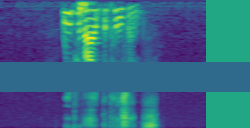

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
0.21s-4.21s of original clip


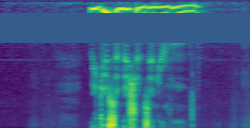

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


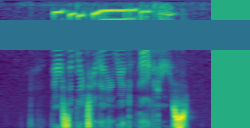

In [304]:
config_sg = AudioConfig(use_spectro=True, duration=4000)
db_sg = (AudioList.from_folder(data_folder, config=config_sg).
         split_by_rand_pct(.2, seed=4).
         label_from_re(label_pattern).
         transform(tfms).
         databunch(bs=32))
db_sg.show_batch()

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


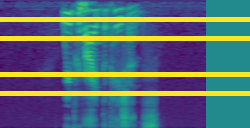

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
0.37s-4.37s of original clip


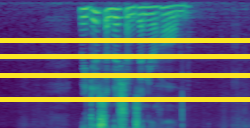

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


In [ ]:
# use 4 masks of 5 rows each and set the mask_value to be 42
tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False, fmasks=4, num_rows=5, fmask_value=42)
db_sg = (AudioList.from_folder(data_folder, config=config_sg).
         split_by_rand_pct(.2, seed=4).
         label_from_re(label_pattern).
         transform(tfms).
         databunch(bs=32))
db_sg.show_batch()

### Time Masking

Time masking is much the same as frequency masking, except the bars are vertical thus blocking time info, and the arguments used to customize have slightly different names

1. tmasks=1 - t instead of f, this is the number of masks to create 
2. num_cols=30 - how many cols should it mask (1 col = 1 pixel)
3. start_col=None - Do you want it to start at a certain col? If None, then it will choose a col at random each time (recommended) 
4. tmask_value=None - Do you want it to mask the sg with a specific value? If None, then it will use the mean of the channel.

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


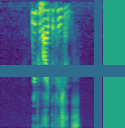

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
0.19s-4.19s of original clip


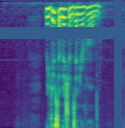

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


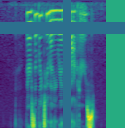

In [11]:
# now let's check out with time and frequency masking, but let's tone down the size a bit
config_sg = AudioConfig(use_spectro=True, duration=4000)
tfms = get_spectro_transforms(mask_time=True, mask_freq=True, roll=False, num_rows=12, num_cols=8);tfms
db_sg = (AudioList.from_folder(data_folder, config=config_sg).
         split_by_rand_pct(.2, seed=4).
         label_from_re(label_pattern).
         transform(tfms).
         databunch(bs=32))
db_sg.show_batch()

## Rolling 

Rolling a spectrogram just means shifting along it's x-axis and wrapping around from the end to the beginning as to not lose any information. Whether this is useful to you depends on your data. Ask yourself if your data would make sense a bit out of order. Traffic noise wrapped would still be traffic noise, but the word "hello" wouldn't be the word "hello". Also, if you are using mixup and specAugment, you may have confused your model sufficiently that rolling isn't going to help. Still we've found it to help in some cases so it is included.

Note that the green bar you're seeing is not a mask, but is actually the padding at the end of the spectrogram that has now been rolled randomly to somewhere in the middle

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


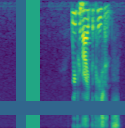

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
0.1s-4.1s of original clip


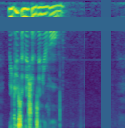

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


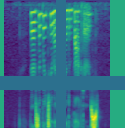

In [16]:
config_sg = AudioConfig(use_spectro=True, duration=4000)
tfms = get_spectro_transforms(mask_time=True, mask_freq=True, roll=True, num_rows=14, num_cols=10);tfms
db_sg = (AudioList.from_folder(data_folder, config=config_sg).
         split_by_rand_pct(.2, seed=4).
         label_from_re(label_pattern).
         transform(tfms).
         databunch(bs=32))
db_sg.show_batch()

Finally let's train our speaker model using specaugment and rolling and see how it does. Keep in mind that we are hiding information from the model as it trains, so it may seem initially to be worse (after the same number of epochs) but this type of augmentation will allow you to train longer without overfitting, sometimes reaching higher accuracies than would be possible without the augmentation.

You can see below from `lr_find()` that the curve isn't as steep.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


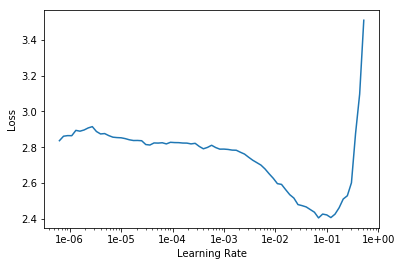

In [17]:
learn = audio_learner(db_sg)
learn.lr_find();learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(7e-3, 7e-2))
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3))

# Conclusion

That's it, from here we recommend you go code and try this stuff out on your own dataset. Follow Jeremy's advice, change settings, see what goes in and what comes out, and adjust. Once you've done that and feel comfortable with the settings, check out our kaggle audio competition notebooks to see how to tune things and get world class results. 

Also we would love feedback, bug reports, feature requests, and whatever else you have to offer. We welcome contributors of all skill levels. If you need to get in touch for any reason, please post in the [fastai audio thread](https://forums.fast.ai/t/deep-learning-with-audio-thread/38123) or contact us via PM [@baz](https://forums.fast.ai/u/baz/) or [@madeupmasters](https://forums.fast.ai/u/MadeUpMasters/). Let's build an audio machine learning community!